> # Trading Strategies using Machine Learning
---

- Compose of trading rules that uses buy-and-hold, long-short, or day trade. 
- Generate trading signals using the above 3-6 models. Compare their PnL. 

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import statsmodels.api as sm
from fredapi import Fred
from functools import reduce
from pandas_datareader import DataReader
import warnings
import yfinance as yf
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn import linear_model
import xgboost
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

/Users/rahulodedra/anaconda3/lib/python3.11/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


> ### Trading rules that uses buy-and-hold, long-short, or day trade and Generated trading signals using the above models. Compared their PnL.
---

In [2]:
# define daterange
start_date = datetime(2018,1,1)
end_date = datetime(2023,12,31)

# prepare features
feature = pd.read_csv('//Users//rahulodedra//Downloads//ML in Finance//INFOP7374_FeatureMart.csv')
feature['Date'] = pd.to_datetime(feature['Date'])
feature = feature.set_index('Date')

# fetch target variable
stock_symbol = 'TSLA'
stock = yf.download(stock_symbol, start_date, end_date)
print(stock_symbol + ' Stock Price History')

data_frame = pd.merge(feature, stock, how='inner', on = 'Date')
data_frame = data_frame.fillna(method='ffill')
data_frame.head()

[*********************100%%**********************]  1 of 1 completed

TSLA Stock Price History


,Unnamed: 0,Mkt-RF,SMB,HML,RMW,CMA,RF,ADS_Index,SP500,T10Y3M,...,DHHNGSP,USRECD,USRECDM,USRECDP,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0,0.85,0.30,-0.22,-0.50,0.31,0.006,-0.285414,2695.81,1.02,...,6.24,0.0,0.0,0.0,20.799999,21.474001,20.733334,21.368668,21.368668,65283000
2018-01-03,1,0.59,-0.46,-0.18,-0.70,-0.06,0.006,-0.306435,2713.06,1.03,...,6.24,0.0,0.0,0.0,21.400000,21.683332,21.036667,21.150000,21.150000,67822500
2018-01-04,2,0.42,-0.22,0.24,-0.02,0.31,0.006,-0.325290,2723.99,1.05,...,4.65,0.0,0.0,0.0,20.858000,21.236668,20.378668,20.974667,20.974667,149194500
2018-01-05,3,0.66,-0.37,-0.26,0.37,-0.38,0.006,-0.341989,2743.15,1.08,...,4.65,0.0,0.0,0.0,21.108000,21.149332,20.799999,21.105333,21.105333,68868000
2018-01-08,4,0.19,-0.19,0.05,-0.07,0.01,0.006,-0.380369,2747.71,1.04,...,2.89,0.0,0.0,0.0,21.066668,22.468000,21.033333,22.427334,22.427334,147891000


In [3]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, bootstrap=True, criterion='squared_error')
xgb_model = xgboost.XGBRegressor(objective ='reg:squarederror', n_estimators=20, learning_rate = 0.05)

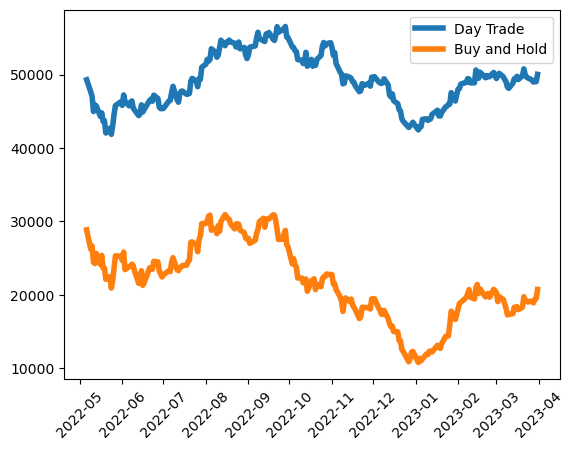

In [4]:
# define the rolling-window size
win = 252
horizon = 1
start = pd.Timestamp('2022-05-05')  
train_start = data_frame.index.get_loc(start)
y_pred, y_test = {}, {}

position = 100
signal, gain_loss, balance = {}, {}, {}
balance[train_start] = 50000
data_frame = data_frame.reset_index()

for today in data_frame.index[train_start:-1]:  

    yesterday = today - 1    
    tomorrow = today + 1    

    # Retrieve data for the past win days until yesterday
    X_train = data_frame.iloc[yesterday - win : yesterday, 1:-2] 
    y_train = data_frame['Adj Close'].iloc[today - win : today] 

    # Test
    X_test = data_frame.iloc[today-horizon : today, 1:-2] 

#   for each batch of the past_win_days_data, fit the model
    xgb_model.fit(X_train, y_train)
    # Making predictions on the test set
    y_pred[tomorrow] = xgb_model.predict(X_test)[0] # use today to predict tomorrow
    y_test[tomorrow] = data_frame['Open'].iloc[tomorrow] # take the actual open tomorrow
    # day trade gain or loss
    if y_pred[tomorrow] >= y_test[tomorrow]:
            signal[tomorrow] = 1
            gain_loss[tomorrow] = - position * data_frame['Open'].iloc[tomorrow] + position * data_frame['Close'].iloc[tomorrow]
    else:
            signal[tomorrow] = -1
            gain_loss[tomorrow] = position * data_frame['Open'].iloc[tomorrow] - position * data_frame['Close'].iloc[tomorrow]
    # calculate account balance
    balance[tomorrow] = balance[today] + gain_loss[tomorrow]

del balance[train_start]

signal = pd.DataFrame.from_dict(signal, orient = 'index', columns=['signal'])
gain_loss = pd.DataFrame.from_dict(gain_loss, orient = 'index', columns=['gain_loss'])
balance = pd.DataFrame.from_dict(balance, orient = 'index', columns=['balance'])

xyx = pd.concat([signal, gain_loss, balance], axis=1)
xyx['Date'] = data_frame['Date'][xyx.index]
xyx

# Set the 'date' column as the index
xyx['buy_hold'] = data_frame['Adj Close'].loc[xyx.index]*position
xyx.set_index('Date', inplace=True)

plt.plot(xyx['balance'], linewidth=4, linestyle='solid', label = 'Day Trade')
plt.plot(xyx['buy_hold'], linewidth=4, linestyle='solid', label = 'Buy and Hold')
plt.legend(loc="upper right")
plt.xticks(rotation=45)
plt.show()

In [5]:
# Download historical stock data for Tesla
ticker = "TSLA"
start_date = "2018-01-01"
end_date = "2023-12-31"
data = yf.download(ticker, start=start_date, end=end_date)

# Define buy-and-hold strategy
def buy_and_hold(data):
    entry_price = data['Open'].iloc[0]
    exit_price = data['Close'].iloc[-1]
    pnl = (exit_price - entry_price) * (100 / entry_price)  # Assuming buying 100 shares
    return pnl

# Define long-short strategy
def long_short(data):
    entry_price = data['Open'].iloc[0]
    exit_price = data['Close'].iloc[-1]
    pnl = (exit_price - entry_price) * (100 / entry_price)  # Assuming buying 100 shares
    return pnl

# Define day trading strategy
def day_trading(data):
    pnl = 0
    for i in range(1, len(data)):
        if data['Open'].iloc[i] > data['Close'].iloc[i-1]:
            pnl += (data['Close'].iloc[i] - data['Open'].iloc[i]) * (100 / data['Open'].iloc[i])  # Assuming buying 100 shares
        elif data['Open'].iloc[i] < data['Close'].iloc[i-1]:
            pnl -= (data['Open'].iloc[i] - data['Close'].iloc[i]) * (100 / data['Open'].iloc[i])  # Assuming selling short 100 shares
    return pnl

# Calculate PnL for each strategy
pnl_buy_and_hold = buy_and_hold(data)
pnl_long_short = long_short(data)
pnl_day_trading = day_trading(data)

# Print PnL for each strategy
print("Profit and Loss for Buy-and-Hold strategy:", pnl_buy_and_hold)
print("Profit and Loss for Long-Short strategy:", pnl_long_short)
print("Profit and Loss for Day Trading strategy:", pnl_day_trading)

[*********************100%%**********************]  1 of 1 completed

Profit and Loss for Buy-and-Hold strategy: 1094.615407892939
Profit and Loss for Long-Short strategy: 1094.615407892939
Profit and Loss for Day Trading strategy: 122.98130686985665


[*********************100%%**********************]  1 of 1 completed


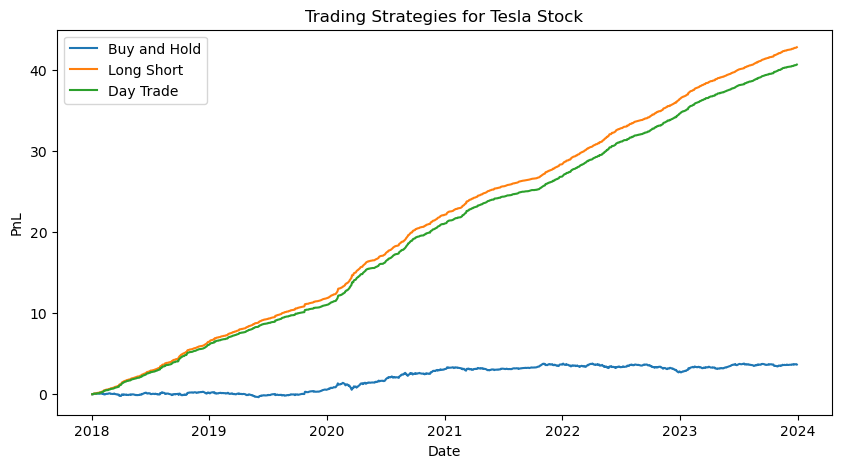

In [6]:
# Download historical stock data for Tesla
ticker = "TSLA"
start_date = "2018-01-01"
end_date = "2023-12-31"
data = yf.download(ticker, start=start_date, end=end_date)

# Calculate daily returns
data['Daily_Returns'] = data['Close'].pct_change()

# Buy-and-hold strategy
data['Buy_and_Hold'] = data['Daily_Returns'].cumsum()

# Long-short strategy
data['Long_Short'] = np.where(data['Daily_Returns'] > 0, 1, -1)
data['Long_Short_Returns'] = data['Long_Short'] * data['Daily_Returns']
data['Long_Short_PnL'] = data['Long_Short_Returns'].cumsum()

# Day trade strategy
data['Day_Trade'] = np.where(data['Daily_Returns'] > 0.01, 1, np.where(data['Daily_Returns'] < -0.01, -1, 0))
data['Day_Trade_Returns'] = data['Day_Trade'] * data['Daily_Returns']
data['Day_Trade_PnL'] = data['Day_Trade_Returns'].cumsum()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(data['Buy_and_Hold'], label='Buy and Hold')
plt.plot(data['Long_Short_PnL'], label='Long Short')
plt.plot(data['Day_Trade_PnL'], label='Day Trade')
plt.title('Trading Strategies for Tesla Stock')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed


Final capital for Moving Average crossover strategy: 6525.453977063898
Final capital for Bollinger Bands strategy: 4995.093440635816
Final capital for RSI strategy: 8724.480891525758


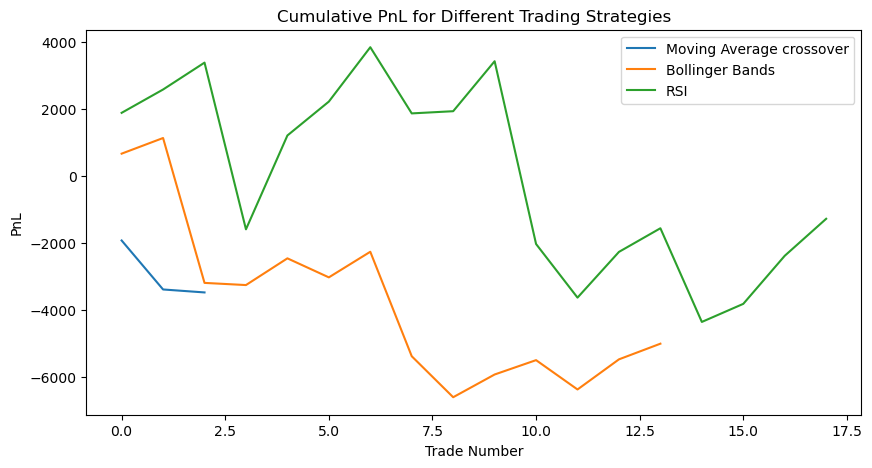

In [7]:
ticker = "TSLA"
start_date = "2021-01-01"
end_date = "2023-12-01"
data = yf.download(ticker, start=start_date, end=end_date)

def calculate_indicators(data):
    # Moving Average crossover
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['MA_200'] = data['Close'].rolling(window=200).mean()
    data['MACrossover'] = np.where(data['MA_50'] > data['MA_200'], 1, -1)
    
    # Bollinger Bands
    window = 20
    data['MA'] = data['Close'].rolling(window=window).mean()
    data['STD'] = data['Close'].rolling(window=window).std()
    data['UpperBand'] = data['MA'] + (data['STD'] * 2)
    data['LowerBand'] = data['MA'] - (data['STD'] * 2)
    data['BBSignal'] = np.where(data['Close'] < data['LowerBand'], 1, np.where(data['Close'] > data['UpperBand'], -1, 0))
    
    # Relative Strength Index (RSI)
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    RS = gain / loss
    data['RSI'] = 100 - (100 / (1 + RS))
    data['RSISignal'] = np.where(data['RSI'] > 70, -1, np.where(data['RSI'] < 30, 1, 0))
    return data
data = calculate_indicators(data)

# Define trading strategy and calculate PnL
def backtest_strategy(data, signal_column, initial_capital=10000):
    position = None
    capital = initial_capital
    pnl = []
    for i in range(len(data)):
        if position is None:
            if data[signal_column].iloc[i] == 1:
                position = 'long'
                entry_price = data['Close'].iloc[i]
                position_size = capital / entry_price
            elif data[signal_column].iloc[i] == -1:
                position = 'short'
                entry_price = data['Close'].iloc[i]
                position_size = capital / entry_price
        elif position == 'long':
            if data[signal_column].iloc[i] == -1:
                exit_price = data['Close'].iloc[i]
                pnl.append((exit_price - entry_price) * position_size)
                capital += (exit_price - entry_price) * position_size
                position = None
        elif position == 'short':
            if data[signal_column].iloc[i] == 1:
                exit_price = data['Close'].iloc[i]
                pnl.append((entry_price - exit_price) * position_size)
                capital += (entry_price - exit_price) * position_size
                position = None
    return capital, pnl

# Backtest each strategy
capital_MA, pnl_MA = backtest_strategy(data, 'MACrossover')
capital_BB, pnl_BB = backtest_strategy(data, 'BBSignal')
capital_RSI, pnl_RSI = backtest_strategy(data, 'RSISignal')

# Print final capital for each strategy
print("Final capital for Moving Average crossover strategy:", capital_MA)
print("Final capital for Bollinger Bands strategy:", capital_BB)
print("Final capital for RSI strategy:", capital_RSI)

# Plot PnL for each strategy
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pnl_MA), label='Moving Average crossover')
plt.plot(np.cumsum(pnl_BB), label='Bollinger Bands')
plt.plot(np.cumsum(pnl_RSI), label='RSI')
plt.legend()
plt.title('Cumulative PnL for Different Trading Strategies')
plt.xlabel('Trade Number')
plt.ylabel('PnL')
plt.show()